# Instruire clasificatorul de fructe
## Experimentand cu Callbacks
    ### Sa crem generatorul de date

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os

#parametri
num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 16

#de unde lum datele de instruire si validare
train_data_dir = "c:/Users/Harum/Documents/12/fruits-360/train"
validation_data_dir = "c:/Users/Harum/Documents/12/fruits-360/validation"

#Utilizam cateva data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size =(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Using TensorFlow backend.
Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


# Definirea modelului

In [2]:
model = Sequential()

#Padding = 'same' duce la padding(umplerea) intrării astfel încât ieșirea să #aibă aceeași lungime ca intrarea inițială

model.add(Conv2D(32, (3,3), padding='same', input_shape=(img_rows,img_cols,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#inițiați optimizatorul RMSprop și configurați unii parametri
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
________________________________________________

In [3]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("c:/Users/Harum/Documents/12/fruits_fresh_cnn_v1.h5",
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1 
)

earlystop = EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1,
                        restore_best_weights=True
 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.2,
                               patience=3,
                               verbose=1,
                               min_delta=0.0001
                                )

#vom pune callbacks intr-o lista callback 
callbacks = [earlystop, checkpoint, reduce_lr]

#Folosim o  rata de invatare foarte mica
model.compile(RMSprop(lr = 0.001),
              'categorical_crossentropy',
              ['accuracy'])

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch= nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2582/2582 [==============================] - 566s 219ms/step - loss: 1.8473 - accuracy: 0.4459 - val_loss: 0.0030 - val_accuracy: 0.7307

Epoch 00001: val_loss improved from inf to 0.00298, saving model to c:/Users/Harum/Documents/12/fruits_fresh_cnn_v1.h5
Epoch 2/10
2582/2582 [==============================] - 77s 30ms/step - loss: 0.6768 - accuracy: 0.7854 - val_loss: 0.7644 - val_accuracy: 0.7955

Epoch 00002: val_loss did not improve from 0.00298
Epoch 3/10
2582/2582 [==============================] - 75s 29ms/step - loss: 0.5268 - accuracy: 0.8424 - val_loss: 1.4916e-04 - val_accuracy: 0.9212

Epoch 00003: val_loss improved from 0.00298 to 0.00015, saving model to c:/Users/Harum/Documents/12/fruits_fresh_cnn_v1.h5
Epoch 4/10
2582/2582 [==============================] - 72s 28ms/step - loss: 0.4905 - accuracy: 0.8614 - val_loss: 1.2480e-06 - val_accuracy: 0.9398

Epoch 00004: val_loss improved from 0.00015 to 0.00000, savin

# Afisare Confusion Matrix

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#Confution Matrix and Classifaction Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples// batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Raport')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 82   0   0 ...   0   0   0]
 [  0 156   0 ...   0   0   0]
 [  0   0  30 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0 249]]
Classification Raport
                     precision    recall  f1-score   support

     Apple Braeburn       0.39      0.50      0.44       164
     Apple Golden 1       0.93      0.95      0.94       164
     Apple Golden 2       1.00      0.18      0.31       164
     Apple Golden 3       0.50      0.93      0.65       161
 Apple Granny Smith       0.90      1.00      0.95       164
        Apple Red 1       1.00      0.85      0.92       164
        Apple Red 2       0.68      1.00      0.81       164
        Apple Red 3       0.81      0.75      0.78       144
Apple Red Delicious       1.00      1.00      1.00       166
   Apple Red Yellow       1.00      0.82      0.90       164
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      

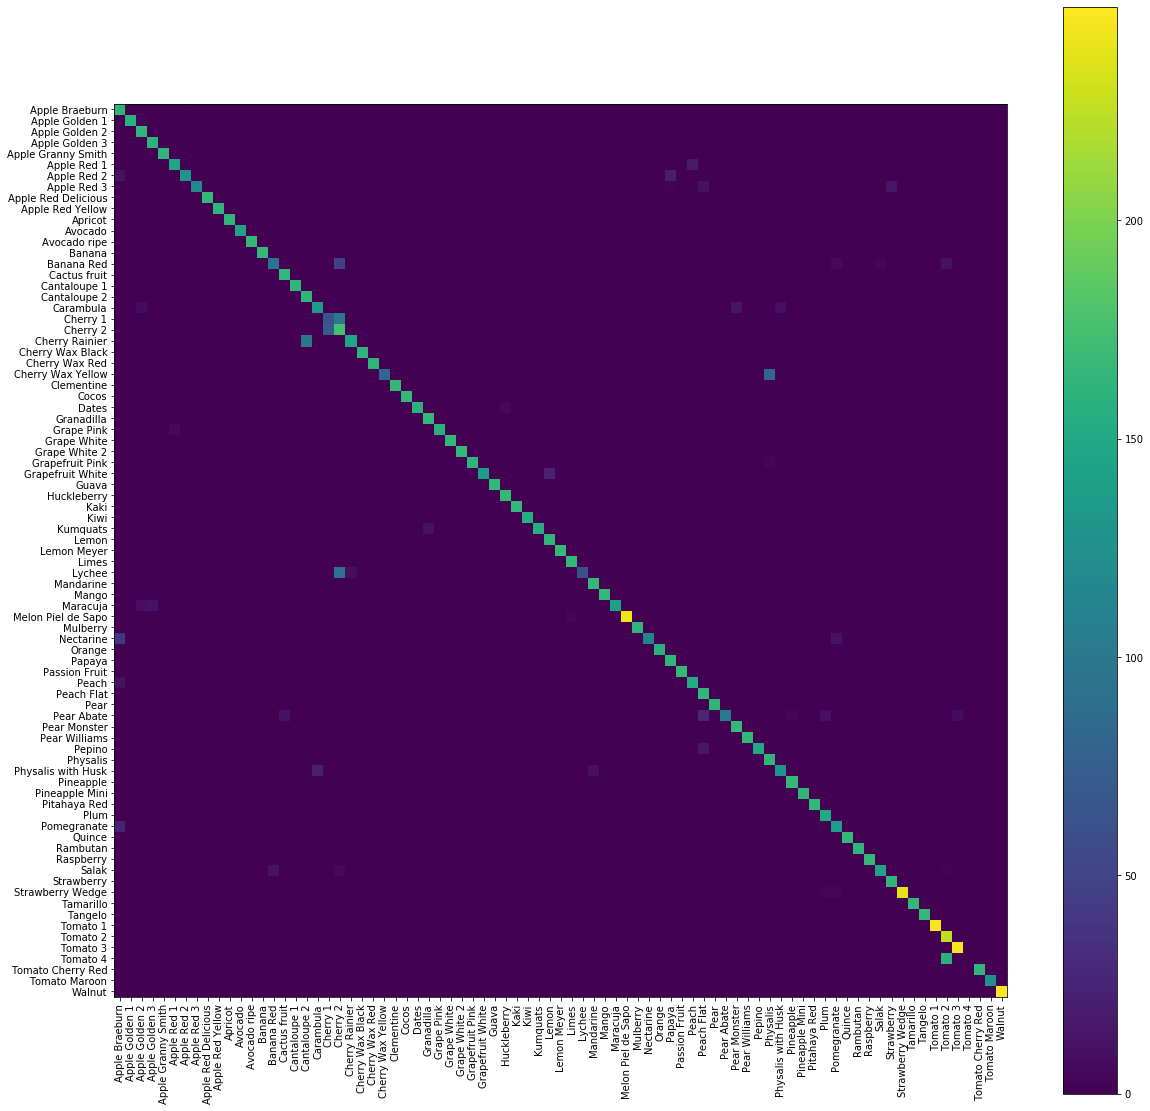

In [8]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_rows, img_height, img_depth = 32,32,3
model = load_model('c:/Users/Harum/Documents/12/fruits_fresh_cnn_v1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 41322
nb_validation_samples = 13877

#Confution MAtrix si Classifaction Raport
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

# Testare clasificatorul fruit

In [14]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re

def draw_test (name, pred, im, true_label):
    BLACK = [0, 0, 0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0,0 ,500, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "predited - " + pred, (20, 60),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(expanded_image, "true - " + true_label, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path, img_width, img_height):
     folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)), os.listdir(path)))
     random_directory = np.random.randint(0, len(folders))
     path_class = folders[random_directory]
     file_path = path +path_class
     file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
     random_file_index = np.random.randint(0, len(file_names))
     image_name = file_names[random_file_index]
     final_path = file_path + "/" +image_name
     return image.load_img(final_path, target_size=(img_width, img_height)),final_path, path_class

#dimensionarea imaginilor
img_width, img_height = 32, 32

files = []
predictions = []
true_labels = []
for i in range (0, 10):
    path = 'c:/Users/Harum/Documents/12/fruits-360/validation/'
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x*1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=10)
    predictions.append(classes)

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

# R

# E